In [178]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [179]:
import torch
from matplotlib import pyplot as plt
from pathlib import Path
import numpy as np
from easydict import EasyDict as edict
from functools import partial

from iterative_sir.sampling_utils.flows import RNVP
from iterative_sir.sampling_utils.adaptive_mc import FlowMCMC, Ex2MCMC, adaptive_sir_correlated_dynamics
from iterative_sir.sampling_utils.distributions import Distribution, IndependentNormal, GaussianMixture

In [180]:
target_args = edict()
target_args.locs = torch.FloatTensor([[-1, 0], [1, 0]])

target = GaussianMixture(**target_args)

/home/evgeny/gans_sampling/iterative_sir/sampling_utils/distributions.py:140: UserWarning: The following kwargs were not used by contour: 'aspect'
  plt.contourf(vals, extent=[*xlim, *ylim], cmap='Greens', alpha=0.5, aspect='auto')


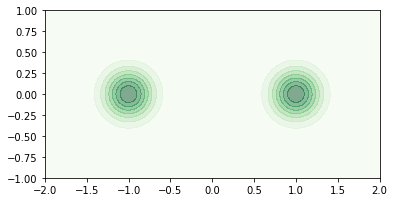

In [181]:
fig, xlim, ylim = target.plot_2d()
plt.gca().set_aspect("equal")

In [182]:
proposal_args = edict()
proposal_args.dim = 2

proposal = IndependentNormal()

In [241]:
N = 5

flow = RNVP(3, dim=2)
optimizer = torch.optim.Adam(flow.parameters(), lr=0.1) #e-1)
batch_size = int(3e2)

method_args = edict()
method_args.n_steps = 1
method_args.N = N
method_args.corr_coef = 0.9
method_args.bernoulli_prob_corr = 0.5
method_args.grad_step = 1e-1
method_args.noise_scale = (2 * 1e-1) ** .5
method_args.adapt_stepsize = True
method_args.mala_steps = 1

ex2mcmc = Ex2MCMC(**method_args)

trainer = FlowMCMC(target, proposal, flow, optimizer, 'mix_kl', ex2mcmc, batch_size=batch_size)
samples = trainer.train(n_steps=600)

100%|██████████| 600/600 [00:14<00:00, 41.08it/s]


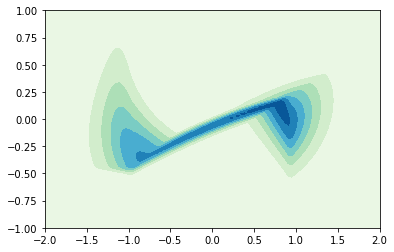

In [242]:
x = np.linspace(-2, 2, 100)
y = np.linspace(-1, 1, 100)

xx, yy = np.meshgrid(x, y)

zz = np.stack([xx, yy], -1)

z = torch.FloatTensor(zz).view(-1, 2)

inv, minus_log_jac = flow.inverse(z)

vals = (proposal(inv) + minus_log_jac).exp()
vals = vals.view(zz.shape[:-1]).detach()

plt.contourf(xx, yy, vals, cmap='GnBu')

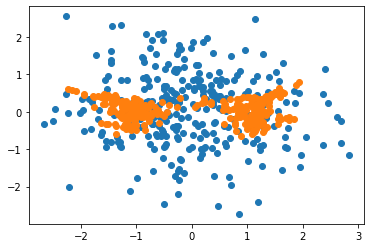

In [225]:
start = proposal.sample((batch_size,))
pushed, _ = flow(start)
pushed = pushed.detach()

plt.scatter(start[:, 0], start[:, 1])
plt.scatter(pushed[:, 0], pushed[:, 1])

In [226]:
x = np.linspace(-3, 3, 100)
y = np.linspace(-1, 1, 100)

xx, yy = np.meshgrid(x, y)

zz = np.stack([xx, yy], -1)



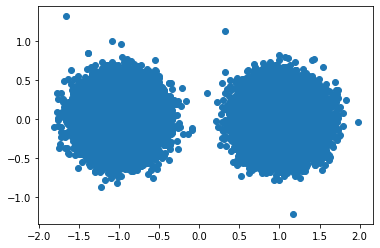

In [227]:
samples = torch.stack(samples, 0).view(-1, 2)

plt.scatter(samples[:, 0], samples[:, 1])

In [243]:
class DotConfig:
    """
    Simple wrapper for config 
    allowing access with dot notation
    """
    def __init__(self, cfg):
        self._cfg = cfg

    def __getattr__(self, k):
        v = self._cfg[k]
        if isinstance(v, dict):
            return DotConfig(v)
        return v

In [245]:
d = DotConfig(dict(g=5))

In [247]:
d.items()

KeyError: 'items'